In [10]:
# Olympics

In [6]:
pip install pandas numpy seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 2000)
pd.set_option('mode.chained_assignment', None)
sns.set(rc={'figure.figsize':(10, 6)})
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style({'font.family':'Sofia Pro'})
flatui = ["#8B0ABE", "#4989F5", "#FE2665", "#F28201", "#FFB624", "#e74c3c", "#34495e"]
sns.set_palette(flatui)

In [2]:
raw_df = pd.read_csv("olympics.csv")

In [3]:
raw_df.head(2)

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [4]:
raw_df['medal'].value_counts(dropna=False, normalize=True)

NaN       0.853262
Gold      0.049322
Bronze    0.049038
Silver    0.048378
Name: medal, dtype: float64

In [5]:
raw_df.isna().mean(axis=0)

id        0.000000
name      0.000000
sex       0.000000
age       0.034944
height    0.221938
weight    0.231912
team      0.000000
noc       0.000000
games     0.000000
year      0.000000
season    0.000000
city      0.000000
sport     0.000000
event     0.000000
medal     0.853262
dtype: float64

<AxesSubplot:xlabel='year', ylabel='id'>

findfont: Font family ['Sofia Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Sofia Pro'] not found. Falling back to DejaVu Sans.


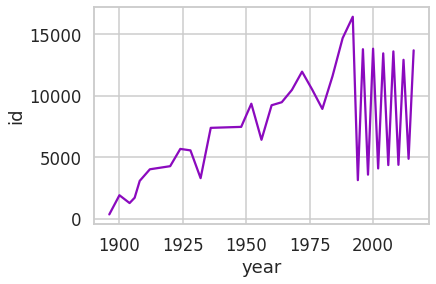

In [6]:
df_to_plot = raw_df.groupby('year', as_index=False)['id'].count().sort_index()
sns.lineplot(data=df_to_plot, x='year',y='id')

<AxesSubplot:xlabel='year', ylabel='id'>

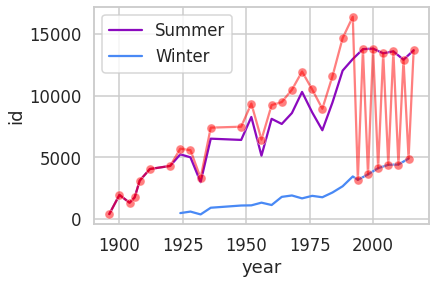

In [7]:
df_to_plot = raw_df.groupby(['year','season'], as_index=False)['id'].count().sort_index()
sns.lineplot(data=df_to_plot, x='year',y='id', hue='season')
df_to_plot = raw_df.groupby('year', as_index=False)['id'].count().sort_index()
sns.lineplot(data=df_to_plot, x='year',y='id', color='red', alpha=0.5, marker='o')

<AxesSubplot:xlabel='year', ylabel='sport'>

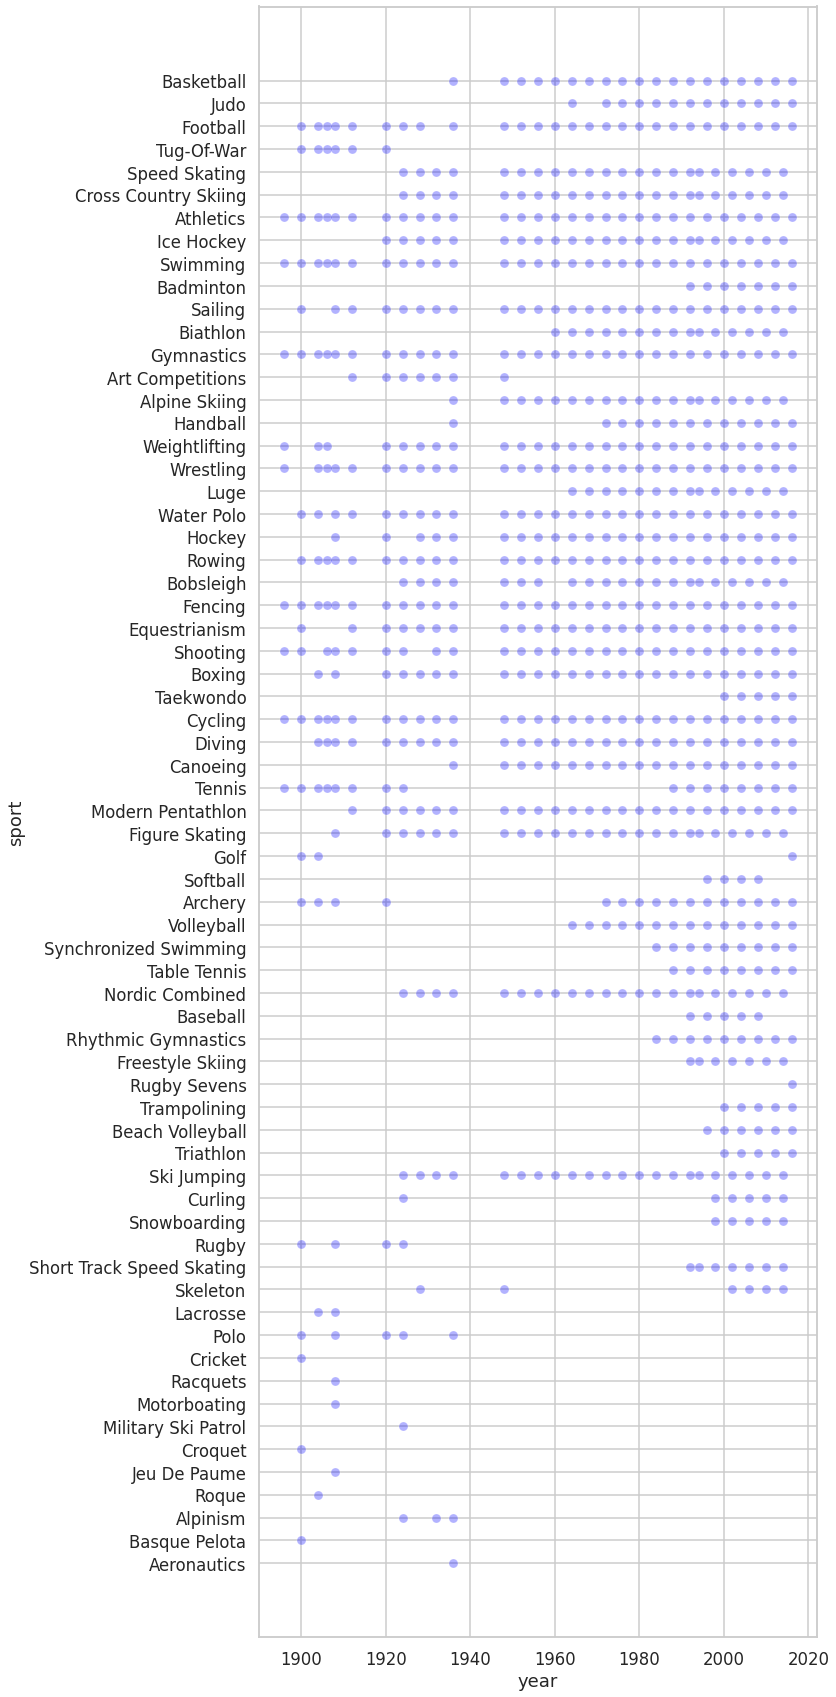

In [8]:
df = raw_df
df_to_plot = df.drop_duplicates(['year','sport'])
fix, ax = plt.subplots(figsize=(10,30))
sns.scatterplot(data=df_to_plot,x='year',y='sport', color = 'blue', alpha=0.3)

In [9]:
df['sex'].value_counts(dropna=False, normalize=True)

M    0.725129
F    0.274871
Name: sex, dtype: float64

In [10]:
df.iloc[0]
df[['team','noc']].nunique()

team    1184
noc      230
dtype: int64

In [11]:
df[['team','noc']]

,team,noc
0,China,CHN
1,China,CHN
2,Denmark,DEN
3,Denmark/Sweden,DEN
4,Netherlands,NED
...,...,...
271111,Poland-1,POL
271112,Poland,POL
271113,Poland,POL
271114,Poland,POL


In [12]:
noc_to_team = (
    df.groupby(['team','noc'],as_index=False)['id']
    .count()
    .rename(columns={'id': 'count'})
    .sort_values('count', ascending=False)
    .groupby('noc')
    ['team']
    .first()
)
df['team_norm']= df['noc'].map(noc_to_team)
df[['team', 'noc','team_norm']]

,team,noc,team_norm
0,China,CHN,China
1,China,CHN,China
2,Denmark,DEN,Denmark
3,Denmark/Sweden,DEN,Denmark
4,Netherlands,NED,Netherlands
...,...,...,...
271111,Poland-1,POL,Poland
271112,Poland,POL,Poland
271113,Poland,POL,Poland
271114,Poland,POL,Poland


In [13]:
df_to_plot = (df.groupby(['team_norm']).agg(count=('sex',len),
                              mean_sex= ('sex', lambda sex: np.mean(sex == 'M'))
                                           )
              .reset_index()
             )

def calc_ci(mu, count, z=1.645):
    return z*np.sqrt((mu*(1-mu))/count)
                                           
df_to_plot['upper_ci'] = df_to_plot.apply(lambda x: x['mean_sex']+calc_ci(x['mean_sex'], x['count']), axis=1)
df_to_plot['lower_ci']=df_to_plot.apply(lambda x: x['mean_sex']-calc_ci(x['mean_sex'], x['count']), axis=1)
df_to_plot.head(2)

,team_norm,count,mean_sex,upper_ci,lower_ci
0,Afghanistan,126,0.960317,0.988925,0.931709
1,Albania,70,0.614286,0.709991,0.518581


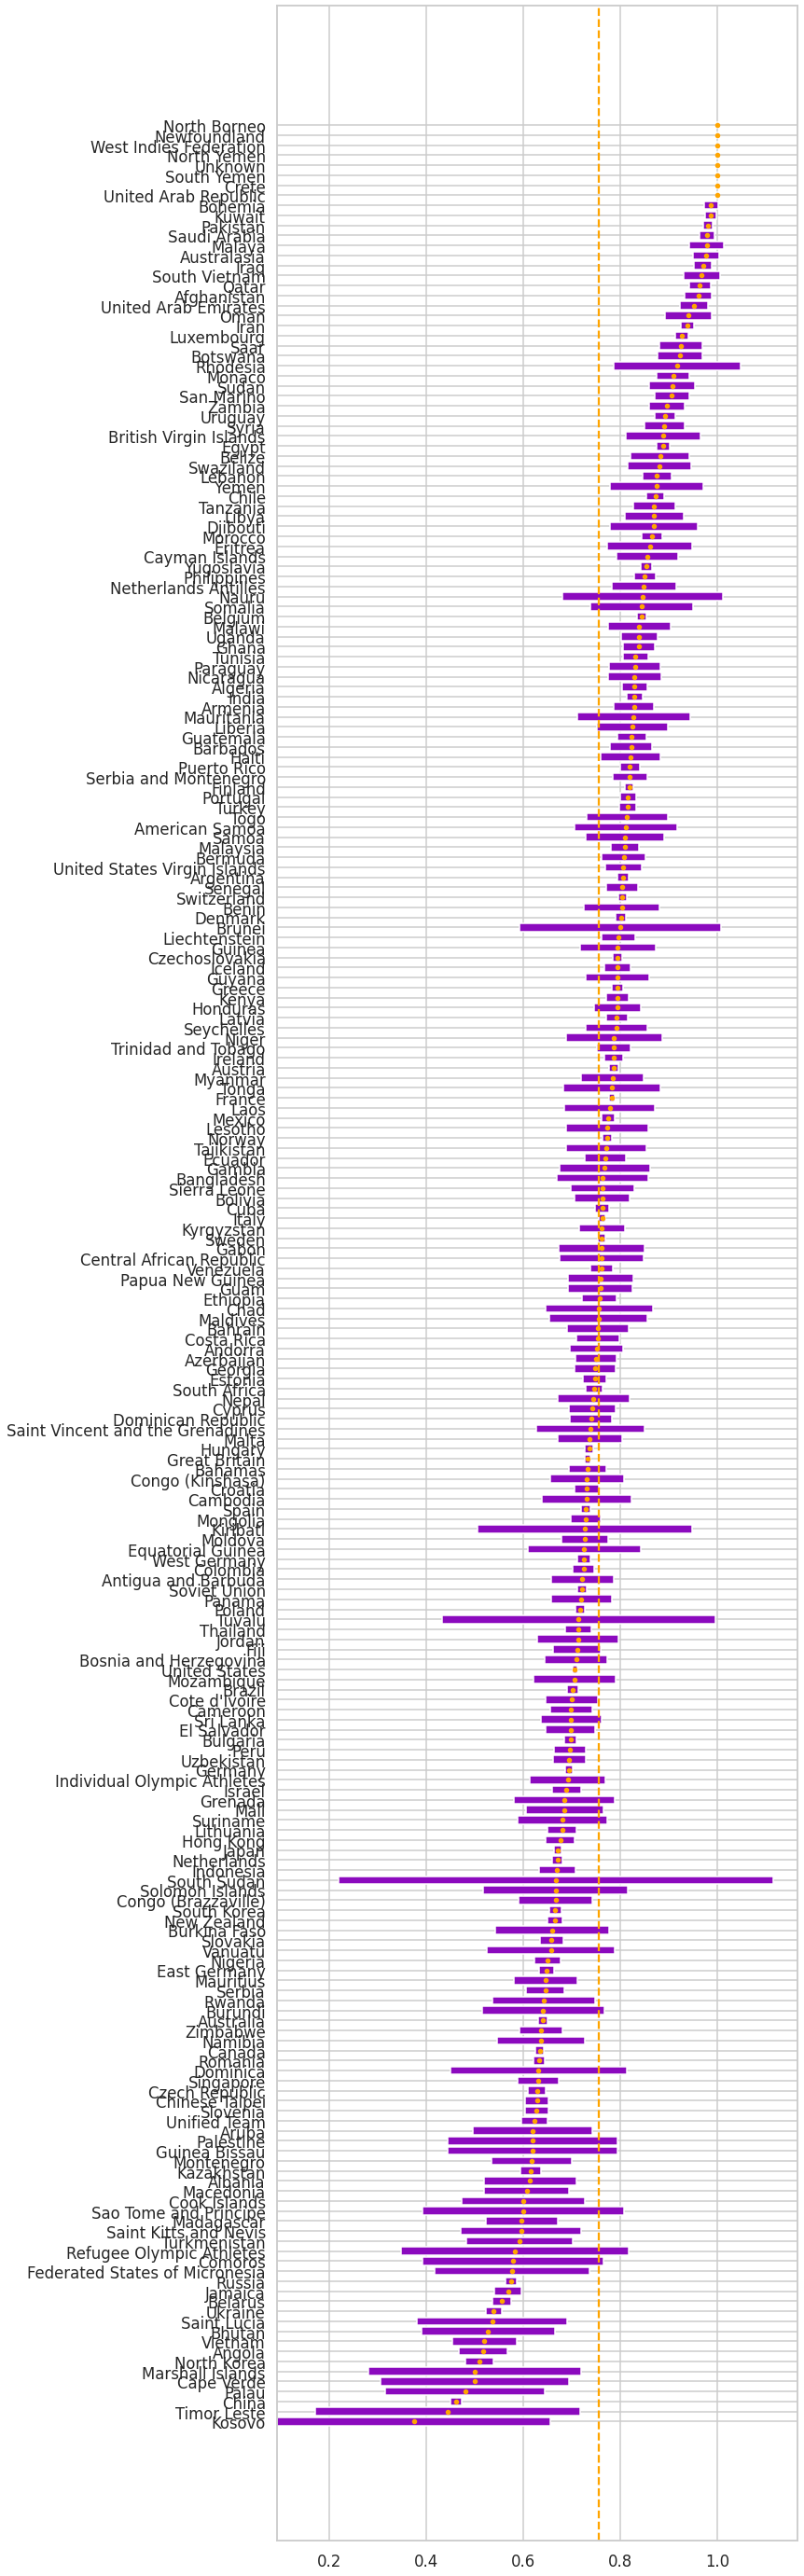

In [14]:
df_to_plot.sort_values(by='mean_sex', inplace=True)

df_to_plot[df_to_plot['count']>=100]
fix, ax = plt.subplots(figsize=(10,50))
plt.barh(y=df_to_plot['team_norm'], width = df_to_plot['upper_ci'] - df_to_plot['lower_ci'], 
         left = df_to_plot['lower_ci'])
plt.scatter(df_to_plot['mean_sex'],df_to_plot['team_norm'], color='orange', s=16)
plt.axvline(df_to_plot['mean_sex'].mean(), linestyle='--', color='orange')
plt.show()

In [15]:
df_to_plot[df_to_plot['team_norm'] =='Israel']

,team_norm,count,mean_sex,upper_ci,lower_ci
97,Israel,665,0.688722,0.718258,0.659186


In [16]:
df_to_plot = df[(df['year'].between(2000,2020)) & (df['medal'].notna())]
df_to_plot['total_medals_in_country'] = df_to_plot.groupby(['team_norm'])['id'].transform(len) 
df_to_plot['total_medals_in_sport'] = df_to_plot.groupby(['sport'])['id'].transform(len) 

df_to_plot = (df_to_plot.groupby(['team_norm','sport'], as_index=False).apply(lambda x: pd.Series({
    'medals_within_country': len(x['id']) / x['total_medals_in_country'].max(),
    'medals_within_sport': len(x['id']) / x['total_medals_in_sport'].max(),
                                                                    }))
             )
                                                                     

In [17]:
#df_to_plot[df_to_plot['team_norm'] =='Israel']['total_medals_in_country']

<AxesSubplot:xlabel='medals_within_country', ylabel='medals_within_sport'>

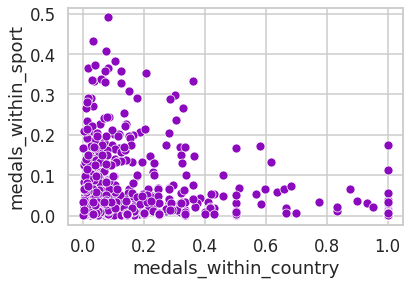

In [18]:
sns.scatterplot(df_to_plot['medals_within_country'], df_to_plot['medals_within_sport']) # information from this plot is not so clear

In [19]:
pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [20]:
from mpld3 import plugins
import mpld3
import ipywidgets
team = 'China'
sport = None
@ipywidgets.interact(
    team = ipywidgets.Dropdown(options=[None]+sorted(df_to_plot['team_norm'].unique())),
    sport = ipywidgets.Dropdown(options=[None]+sorted(df_to_plot['sport'].unique())))
def show_the_big_pic(team, sport):
    if (team is None) == (sport is None):
        print('Please choose either of them')
        return
    
    fig, ax = plt.subplots()

    df_filtered = df_to_plot[(df_to_plot['team_norm']==team) if team is not None
                             else (df_to_plot['sport']==sport)]

    points = ax.plot(df_filtered['medals_within_country'], df_filtered['medals_within_sport'], 'o', color='b', mec='k', ms = 15, mew = 1, alpha = 0.6)
    tooltip = plugins.PointHTMLTooltip(points[0],list(df_filtered['team_norm'] + ' , ' + df_filtered['sport']))
    plugins.connect(fig, tooltip)
    return mpld3.display()

Please choose either of them


interactive(children=(Dropdown(description='team', options=(None, 'Afghanistan', 'Algeria', 'Argentina', 'Arme…